# WT partial differential equation

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the KdV equation. 

In [152]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
import colorcet as cc
import pandas as pd
from iteration_utilities import deepflatten

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)

# Configuring GPU or CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)
#device = "cpu"

def write_model_expression(model_estimator_coeffs, poly_order=2, diff_order=3):
    flatten_list = list(deepflatten(model_estimator_coeffs))
    poly_order_it_array = range(1,poly_order+1)
    diff_order_it_array = range(1,diff_order+1)
    diff_term = 'u_{'
    poly_terms = []
    diff_terms = []
    for diff_order_it in diff_order_it_array:
        diff_term = diff_term+'x'
        full_diff_term = diff_term +'}'
        diff_terms.append(full_diff_term)
    poly_term_0 = 'u^{'    
    for poly_order_it in poly_order_it_array:
        poly_term = poly_term_0+str(poly_order_it)+'}'
        poly_terms.append(poly_term)
    all_model_terms = ['1'] + diff_terms
    cross_terms = []
    for poly_term in poly_terms:
        cross_terms.append(poly_term)
        for diff_term in diff_terms:
            cross_term = poly_term + diff_term
            cross_terms.append(cross_term)
    print(cross_terms)
    all_model_terms = ['1'] + diff_terms + cross_terms
    print(all_model_terms)
    model_string = 'u_{t} = '
    for i in range(len(flatten_list)):
        model_string = model_string + str(flatten_list[i])+'*'+all_model_terms[i]
    return model_string 

cpu


Shape of grid x: (140, 176)
Shape of grid t: (140, 176)
Shape of grid u: (140, 176)


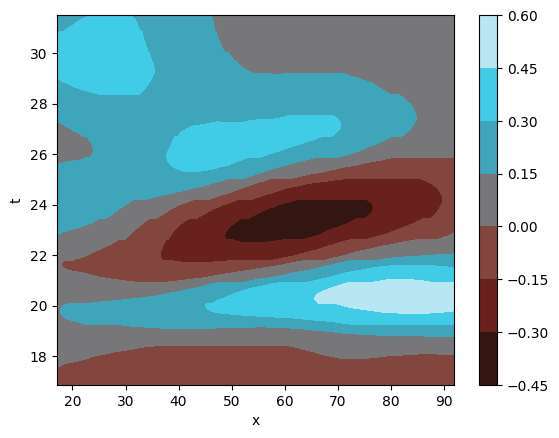

In [109]:
signal_data = pd.read_csv('dataset/signal_matrix_space_data.csv')
time_data = pd.read_csv('dataset/plot_time_label_df.csv')
x = signal_data['nx'].values
t = time_data['frame_in_hours'].values
t,x = np.meshgrid(t,x)
u_data = signal_data.copy()
u_data = u_data.drop(columns=['nx'])
u = np.real(u_data.to_numpy())*10
data = {}
data['x'] = x
print('Shape of grid x:', data['x'].shape)
data['t'] = t
print('Shape of grid t:', data['t'].shape)
data['u'] = u 
print('Shape of grid u:', data['u'].shape)

fig, ax = plt.subplots()
im = ax.contourf(data['x'], data['t'], data['u'], cmap=cc.cm.CET_CBTL2)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()


In [110]:
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))
print('X shape, y shape:', X.shape, y.shape)

X shape, y shape: (24640, 2) (24640, 1)


In [111]:
noise_level = 0.025
y_noisy = y + noise_level * np.std(y) * np.random.randn(y[:,0].size, 1)
#coords = torch.from_numpy(np.stack((t.tolist(),x.tolist()), axis=-1)).float()
#X = coords
#y = u

In [112]:
number_of_samples = 17000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)
print(X_train.shape, y_train.shape)

torch.Size([17000, 2]) torch.Size([17000, 1])


In [113]:
len(idx)

24640

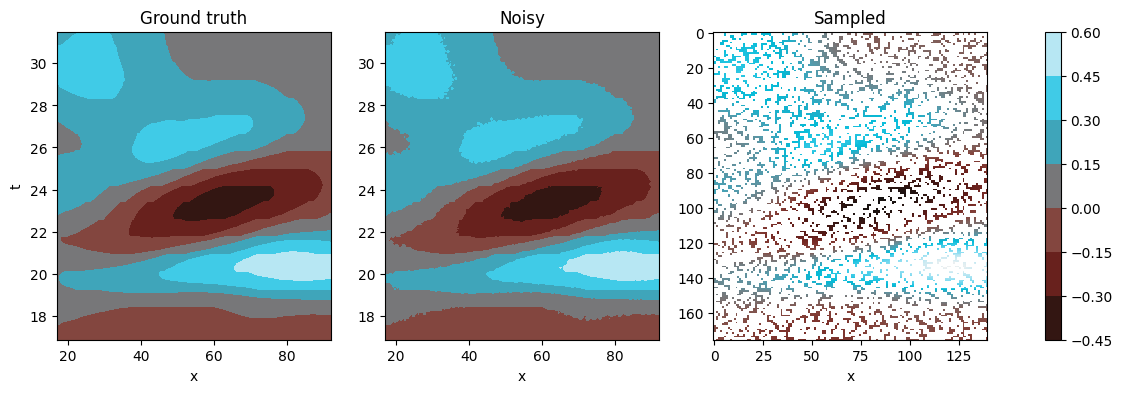

In [114]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap=cc.cm.CET_CBTL2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap=cc.cm.CET_CBTL2)
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap=cc.cm.CET_CBTL2)
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

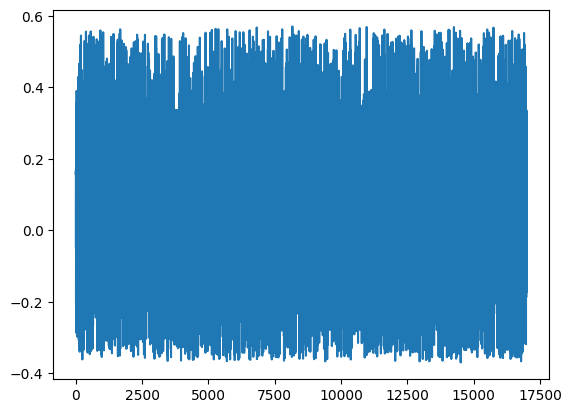

In [115]:
plt.plot(y_train)

Before we send the data into the Dataset format, create a plot to get an idea of the data:

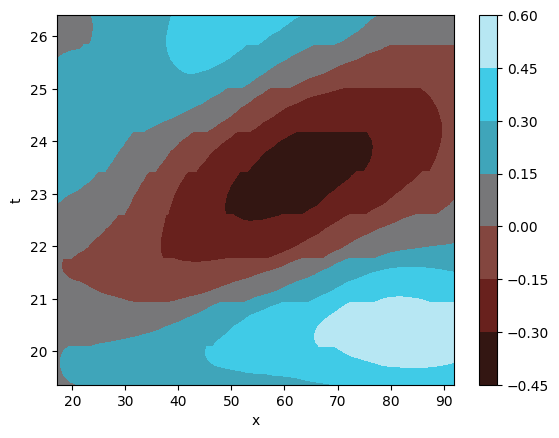

In [124]:
signal_data = pd.read_csv('dataset/signal_matrix_space_data.csv')
x = np.real(signal_data['nx'].values)
t = time_data['frame_in_hours'].values
t_min = int(30)
t_max = int(115)
u_data = signal_data.copy()
u_data = u_data.drop(columns=['nx'])
u_data = u_data.iloc[:,t_min:t_max]
t = np.real(t[t_min:t_max])
u = np.real(u_data.to_numpy())*10
t,x = np.meshgrid(t,x)
fig, ax = plt.subplots()
im = ax.contourf(x, t, u, cmap=cc.cm.CET_CBTL2)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)
plt.show()


We can now define a function that loads the data, makes torch tensors out of it and then returns it in a coords, data format. The shape of the samples will be (t,x) for the input and (u) for the dataset. Ensure that any array is not 1D, so an array with a single feature can be the shape (N,1) using reshape(-1,1) in numpy or unsqueeze(-1) in torch.

In [140]:
def load_data():
    coords = torch.from_numpy(np.stack((t.tolist(),x.tolist()), axis=-1)).float()
    data = torch.from_numpy(u).unsqueeze(-1).float()
    return coords, data

In [141]:
dataset = Dataset(
    load_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 17000},
    device=device,
)

Dataset is using device:  cpu


We now also wish to split the data into a train and test split, specifically into loaders, which handle the logic of passing the samples to the model.

In [144]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.


In [145]:
network = NN(2, [30, 30, 30, 30], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [146]:
library = Library1D(poly_order=2, diff_order=3) 

In [153]:
from deepymod.model.library import library_poly
from deepymod.model.library import library_deriv
library_poly = library_poly(y_train,2)
#library_deriv = library_deriv(load_data_test[0],load_data_test[1],3)

IndexError: index 17000 is out of bounds for dimension 0 with size 17000

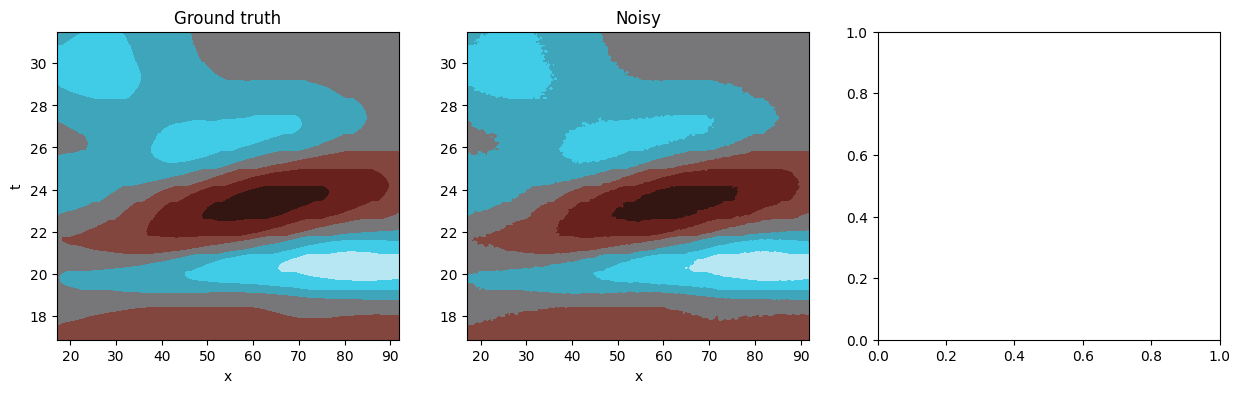

In [155]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap=cc.cm.CET_CBTL2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap=cc.cm.CET_CBTL2)
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap=cc.cm.CET_CBTL2)
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged. 

In [31]:
estimator = Threshold(0.1) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5)

Configuration of the sparsity estimator

In [32]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

In [33]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data:

- The directory where the tensorboard file is written (log_dir)
- The ratio of train/test set used (split)
- The maximum number of iterations performed (max_iterations)
- The absolute change in L1 norm considered converged (delta)
- The amount of epochs over which the absolute change in L1 norm is calculated (patience)



In [34]:
train(model, train_dataloader, test_dataloader, optimizer,sparsity_scheduler, log_dir='runs/test111/', split=0.8, max_iterations=100000)

 91925  MSE: 4.25e-04  Reg: 4.21e-05  L1: 8.76e+00 Algorithm converged. Writing model to disk.


In [107]:
model_sparsity_masks = model.sparsity_masks

AttributeError: 'str' object has no attribute 'sparsity_masks'

In [69]:
poly_order=2
diff_order=3

poly_order_it_array = range(1,poly_order+1)
diff_order_it_array = range(1,diff_order+1)
diff_term = 'u_{'
poly_terms = []
diff_terms = []
for diff_order_it in diff_order_it_array:
    diff_term = diff_term+'x'
    full_diff_term = diff_term +'}'
    print(full_diff_term)
    diff_terms.append(full_diff_term)
poly_term_0 = 'u^{'    
for poly_order_it in poly_order_it_array:
    poly_term = poly_term_0+str(poly_order_it)+'}'
    print(poly_term)
    poly_terms.append(poly_term)
all_model_terms = ['1'] + diff_terms
cross_terms = []
for poly_term in poly_terms:
    cross_terms.append(poly_term)
    for diff_term in diff_terms:
        cross_term = poly_term + diff_term
        cross_terms.append(cross_term)
print(cross_terms)
all_model_terms = ['1'] + diff_terms + cross_terms
print(all_model_terms)

u_{x}
u_{xx}
u_{xxx}
u^{1}
u^{2}
['u^{1}', 'u^{1}u_{x}', 'u^{1}u_{xx}', 'u^{1}u_{xxx}', 'u^{2}', 'u^{2}u_{x}', 'u^{2}u_{xx}', 'u^{2}u_{xxx}']
['1', 'u_{x}', 'u_{xx}', 'u_{xxx}', 'u^{1}', 'u^{1}u_{x}', 'u^{1}u_{xx}', 'u^{1}u_{xxx}', 'u^{2}', 'u^{2}u_{x}', 'u^{2}u_{xx}', 'u^{2}u_{xxx}']


* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

* $u_t = C_0+ C_1u_x + u^2 (C_2 + C_4 u_{x})$

In [106]:
model_estimator_coeffs = model.estimator_coeffs() 

AttributeError: 'str' object has no attribute 'sparsity_masks'

In [151]:
print(model.estimator_coeffs())

AttributeError: 'str' object has no attribute 'estimator_coeffs'

AttributeError: 'str' object has no attribute 'estimator_coeffs'

Before we send the data into the Dataset format, create a plot to get an idea of the data:

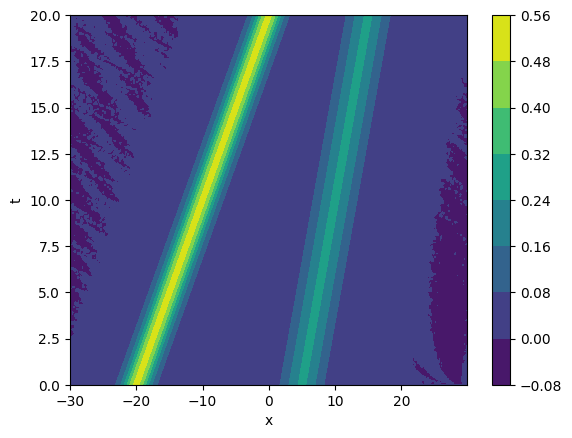

In [27]:
data = np.load('data/kdv.npy', allow_pickle=True).item()
fig, ax = plt.subplots()
im = ax.contourf(data['x'], data['t'], np.real(data['u']))
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)

plt.show()

In [28]:
data['u']

array([[9.07916333e-05+0.00000000e+00j, 6.64889818e-05+1.26026714e-07j,
        5.89067020e-05+3.75270061e-07j, ...,
        1.60500615e-05+3.95709529e-07j, 1.07850861e-05-6.96376780e-07j,
        1.57129634e-05+7.78432383e-07j],
       [1.02078624e-04+0.00000000e+00j, 7.83560113e-05-1.26149488e-07j,
        7.04022394e-05-3.75418244e-07j, ...,
        1.76362653e-05-3.97416158e-07j, 1.10488928e-05+6.94792227e-07j,
        1.43221606e-05-7.80501331e-07j],
       [1.14768625e-04+0.00000000e+00j, 9.25800311e-05+1.26271385e-07j,
        7.88339657e-05+3.75561506e-07j, ...,
        9.21694941e-06+3.99121956e-07j, 1.00046020e-05-6.93214826e-07j,
        1.23645879e-05+7.82568151e-07j],
       ...,
       [2.69555303e-08+0.00000000e+00j, 3.33271551e-05-1.25652163e-07j,
        3.20349513e-05-3.74803192e-07j, ...,
        2.32291891e-05-3.90587903e-07j, 1.69938055e-05+7.01170960e-07j,
        2.03811113e-05-7.72216440e-07j],
       [2.48119256e-08+0.00000000e+00j, 3.87749201e-05+1.25778169e-0

We can now define a function that loads the data, makes torch tensors out of it and then returns it in a coords, data format. The shape of the samples will be (t,x) for the input and (u) for the dataset. Ensure that any array is not 1D, so an array with a single feature can be the shape (N,1) using reshape(-1,1) in numpy or unsqueeze(-1) in torch.

In [103]:
def load_data():
    array = np.load('data/kdv.npy', allow_pickle=True).item()
    coords = torch.from_numpy(np.stack((array["t"],array["x"]), axis=-1)).float()
    data = torch.from_numpy(np.real(array["u"])).unsqueeze(-1).float()
    return coords, data

We can now pass the function that loads the data to the DeePyMoD Dataset module, which loads the data, preprocesses it, subsamples it and then sends it to the right device.

In [104]:
dataset = Dataset(
    load_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 2000},
    device=device,
)

Dataset is using device:  cpu


We now also wish to split the data into a train and test split, specifically into loaders, which handle the logic of passing the samples to the model.

In [105]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [106]:
network = NN(2, [30, 30, 30, 30], 1)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [107]:
library = Library1D(poly_order=2, diff_order=3) 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [108]:
estimator = Threshold(0.1) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5) 

Configuration of the sparsity estimator 

In [109]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and select the optimizer 

In [110]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 


## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [111]:
train(model, train_dataloader, test_dataloader, optimizer,sparsity_scheduler, log_dir='runs/KDV/', split=0.8, max_iterations=100000) 

 11550  MSE: 6.96e-07  Reg: 1.50e-06  L1: 2.89e+00 Algorithm converged. Writing model to disk.


Sparsity masks provide the active and non-active terms in the PDE:

In [12]:
model.sparsity_masks

[tensor([False, False, False,  True, False,  True, False, False, False, False,
         False, False], device='cuda:0')]

estimatior_coeffs gives the magnitude of the active terms:

In [13]:
print(model.estimator_coeffs())

[array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.96783626],
       [ 0.        ],
       [-1.7370548 ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)]
